In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (
boston_housing.load_data())

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
 train_data.shape



(404, 13)

13
numerical features, such as per capita crime rate, average number of rooms per dwelling, accessibility to highways, and so on

In [3]:
test_data.shape

(102, 13)

The targets are the median values of owner-occupied homes, in thousands of dollars

In [4]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

It would be problematic to feed into a neural network values that all take wildly different ranges. The model might be able to automatically adapt to such heterogeneous
data, but it would definitely make learning more difficult

Normalizing the data

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

You should never use any quantity computed on the test data in your
workflow

In general, the less training data you have, the worse
overfitting will be, and using a small model is one way to mitigate overfitting.

Model definition

In [8]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
  ])
  model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
  return model

The model ends with a single unit and no activation (it will be a linear layer). This is a
typical setup for scalar regression

we compile the model with the mse loss function—mean squared error, the
square of the difference between the predictions and the targets. This is a widely used
loss function for regression problems.

In [12]:
import numpy as np
import keras
from keras import layers
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
  print(f"Processing fold #{i}")
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
  axis=0)
  partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
  axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
  epochs=num_epochs, batch_size=16, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [13]:
all_scores

[2.072988510131836, 2.3822102546691895, 2.5057222843170166, 2.339646339416504]

In [14]:
np.mean(all_scores)

2.3251418471336365

Saving the validation logs at each fold with n_epochs = 500

In [15]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
  print(f"Processing fold #{i}")
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]],
  axis=0)
  partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]],
  axis=0)
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
  validation_data=(val_data, val_targets),
  epochs=num_epochs, batch_size=16, verbose=0)
  mae_history = history.history["val_mae"]
  all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


Building the history of successive mean K-fold validation scores

In [16]:
average_mae_history = [
np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Plotting validation scores

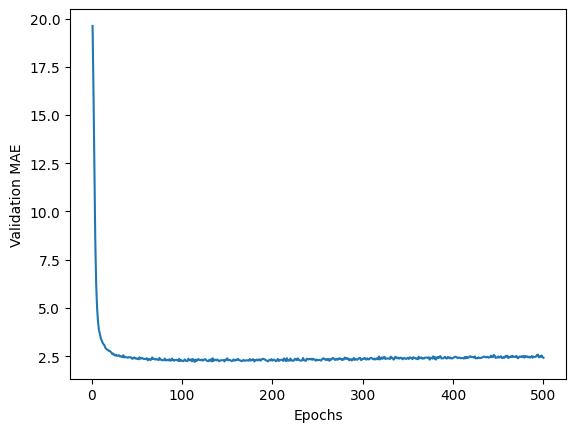

In [18]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

Plotting validation scores, excluding the first 10 data points

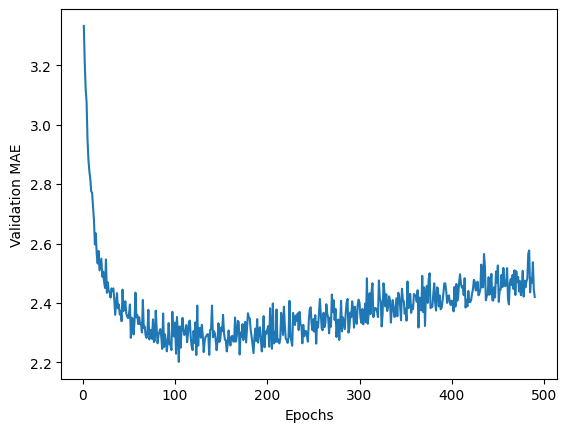

In [19]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

 Training the final model

In [20]:
model = build_model()
model.fit(train_data, train_targets,
epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.2152 - mae: 2.3801 


In [21]:
test_mae_score

2.5486416816711426

with this scalar regression model, predict() returns the model’s guess for the sample’s price in
thousands of dollars

In [22]:
predictions = model.predict(test_data)
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([9.183912], dtype=float32)

Regression is done using different loss functions than we used for classification.
Mean squared error (MSE) is a loss function commonly used for regression.

Similarly, evaluation metrics to be used for regression differ from those used for
classification; naturally, the concept of accuracy doesn’t apply for regression. A
common regression metric is mean absolute error (MAE).

 When features in the input data have values in different ranges, each feature
should be scaled independently as a preprocessing step.

 When there is little data available, using K-fold validation is a great way to reliably evaluate a model.

 When little training data is available, it’s preferable to use a small model with few
intermediate layers (typically only one or two), in order to avoid severe overfitting.

The three most common kinds of machine learning tasks on vector data are
binary classification, multiclass classification, and scalar regression.

– The “Wrapping up” sections earlier in the chapter summarize the important
points you’ve learned regarding each task.

– Regression uses different loss functions and different evaluation metrics
than classification.

 You’ll usually need to preprocess raw data before feeding it into a neural network.

 When your data has features with different ranges, scale each feature independently as part of preprocessing.

 As training progresses, neural networks eventually begin to overfit and obtain
worse results on never-before-seen data.

 If you don’t have much training data, use a small model with only one or two
intermediate layers, to avoid severe overfitting.

 If your data is divided into many categories, you may cause information bottlenecks if you make the intermediate layers too small.

 When you’re working with little data, K-fold validation can help reliably evaluate your model.